In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from bokeh.plotting import figure
import spacy 
from spacy.matcher import Matcher
from spacy.tokens import Doc
from spacy.util import filter_spans
import pandas as pd
import re
from collections import Counter
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import copy
import csv
from datetime import datetime
import random

# configuration
start_post = 0
end_post = 42000

print("imported modules")

imported modules


In [3]:
# Load csv data
filepath = os.path.join(os.getcwd(), 'QueryResults_sample_42636_14_05_21.csv')

stack_posts = pd.read_csv(filepath, sep = ",")

print("loaded csv data")

loaded csv data


In [9]:
stack_posts

,QuestionUserId,QuestionUserReputation,QuestionUserDN,Tags,QuestionId,QuestionScore,title,QuestionBody,QuestionDate,AcceptedAnswer,AnswerUserId,AnswerUserReputation,AnswerUserDN,AnswerScore,AnswerId,AnswerBody,AnswerDate
0,3625340,33,user3625340,<image-processing><machine-learning><svm><feat...,27729199,0,How to find Relevent Features for Comparing Di...,<p>Currently we are doing a project on diagram...,2015-01-01 08:03:13,27733517.0,1056563,45925,StephenBoesch,0,27733517,<p>In regard solely to the difference in scale...,2015-01-01 18:39:02
1,4409773,788,Avis,<java><machine-learning><svm><encog>,27729238,1,SVM using Encog in Java for beginners,<p>I am beginner in SVM. Could someone please ...,2015-01-01 08:10:29,27808712.0,173355,3162,JeffHeaton,1,27808712,<p>In Encog SVM is just a classification or re...,2015-01-06 22:58:03
2,4408281,715,datavinci,<python-2.7><machine-learning>,27730775,1,Why does not the following code snippet run su...,<p>I was reading Programming Collective Intell...,2015-01-01 12:22:49,27730829.0,367273,436785,NPE,1,27730829,<blockquote>\n <p>NameError: global name 'lin...,2015-01-01 12:32:19
3,3512217,119,Shlomi,<machine-learning><svm>,27730870,-1,division of two proper kernels,"<p>Let <img src=""https://i.stack.imgur.com/Z1G...",2015-01-01 12:37:59,NaN,1060350,70610,Has QUIT--Anony-Mousse,0,27742921,"<p>K2(x,z) can be 0.</p>\n\n<p>Then this value...",2015-01-02 13:22:27
4,4405757,14440,user7,<machine-learning><classification><weka><libsv...,27732503,0,One class SVM to detect outliers,<p>My problem is</p>\n\n<blockquote>\n <p>I w...,2015-01-01 16:26:06,NaN,1060350,70610,Has QUIT--Anony-Mousse,5,27739848,<p>Your data is not formatted appropriately fo...,2015-01-02 09:20:50
5,1448255,192,seekme_94,<r><machine-learning><neural-network>,27732566,0,Extreme learning machines in R for discrete at...,<p>I'm trying to run the following example of ...,2015-01-01 16:35:42,NaN,4437789,11,ppp,1,27865953,<p>translate factors to binary representation ...,2015-01-09 17:26:49
6,4410616,61,Rohan Pota,<python-2.7><machine-learning>,27733238,-1,What is the error in the following python code...,<p>I was reading the the chapter on search eng...,2015-01-01 18:03:55,NaN,2058922,743,Bee Smears,0,27736501,<p>You have an SQL error. Start by properly f...,2015-01-02 01:49:11
7,495815,1370,Wouter,<apache-spark><machine-learning><prediction><a...,27734329,18,Incremental training of ALS model,<p>I'm trying to find out if it is possible to...,2015-01-01 20:21:14,NaN,4674497,602,Bartłomiej Twardowski,0,36767722,<p>For updating Your model near-online (I writ...,2016-04-21 11:06:37
8,495815,1370,Wouter,<apache-spark><machine-learning><prediction><a...,27734329,18,Incremental training of ALS model,<p>I'm trying to find out if it is possible to...,2015-01-01 20:21:14,NaN,2220275,737,Dr VComas,4,36917856,<p>I imagine you are using spark MLlib's ALS m...,2016-04-28 14:36:03
9,3423045,978,Deepak,<c++><opencv><machine-learning><svm>,27738986,3,Find confidence of prediction in SVM,<p>I am doing English digit classification usi...,2015-01-02 07:39:41,27739386.0,1190430,5186,Artem Sobolev,10,27739386,<p>SVM during training tries to find a separat...,2015-01-02 08:28:35


In [30]:
def get_date(data_string):
    date = datetime.date(datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S'))
    year = pd.Timestamp(date).year
    quarter = pd.Timestamp(date).quarter
    return year, quarter

def clean_bodys(text):
    text = re.sub(regex_pattern, '', text, flags=re.I)
    text = re.sub('\(|\)', ' ', text, flags=re.I)
    return text

def filter_spans(matches):
    span_list = [doc[match[1]:match[2]] for match in matches]
    filtered_spans = spacy.util.filter_spans(span_list)
    return filtered_spans

In [31]:
# clean posts and match words
nlp = spacy.load("en_core_web_lg")
matcher = Matcher(nlp.vocab)

topic_pattern1 = [{'POS': 'ADJ', 'OP': '?'},
           {'OP': '+', 'POS': 'NOUN'},
           {'POS': 'NOUN', 'OP': '?'}
          ]

matcher.add("match_topic1", [topic_pattern1])

word_set = set()
regex_pattern = '(<(pre|code|blockquote|a|strike)(.|\n)*?\/(pre|code|blockquote|a|strike)>)*?|<(p|b|br|br(.|\n)*?\/|sub|sup|em|strong|hr|s|i|ol|ul|li|code)*?>|<\/(p|b|br|sub|sup|em|strong|s|i|ol|ul|li|div|pre|blockquote|a|code)>|<h(.|\n)*?>(.|\n)*?<\/h(.|\n)*?>*?|(<(img|div|ol|ul|li)(.|\n)*?\/*?>)|\n'
post_df = pd.DataFrame(stack_posts[["QuestionId", "QuestionDate", "QuestionBody", "AnswerId", "AnswerBody", "AnswerDate"]][0:end_post])


# initialize topic frequency counter
topic_frequency_dict = dict()
for year in range(2015, 2022):
    topic_frequency_dict[year] = dict()
    for quarter in range(1, 5):
        topic_frequency_dict[year][quarter] = Counter()
        
for i, line in enumerate(post_df.itertuples()):
    post = pd.DataFrame(line).transpose().drop(0, axis=1)
    post.columns = post_df.columns
    
    # analyze questions    
    if post["QuestionId"][0] != post_df.iloc[i - 1]["QuestionId"]:            
        text = clean_bodys(post["QuestionBody"][0])
        doc = nlp(text)
        matches = matcher(doc)
        
        filtered_spans = filter_spans(matches)
        year, quarter = get_date(post["QuestionDate"][0])     

        for span in filtered_spans:
            topic_frequency_dict[year][quarter][span.text] += 1
    
    # analyze answers
    text = clean_bodys(post["AnswerBody"][0])      
    doc = nlp(text)        
    matches = matcher(doc)
    
    filtered_spans = filter_spans(matches)    
    year, quarter = get_date(post["AnswerDate"][0])   
    
    for span in filtered_spans:
        topic_frequency_dict[year][quarter][span.text] += 1
    
#topic_frequency_dict
#print("finished")

In [ ]:
topic_frequency_df = pd.DataFrame.from_dict(topic_frequency_dict).transpose()
topic_counter = Counter()

for year in topic_frequency_df:
    for quarter in topic_frequency_df[year]:
        topic_counter = sum((topic_counter, quarter), Counter())

#bigger_than_x_counter = Counter({k: c for k,c in topic_counter.items() if c >= 50})
#sorted_counter = bigger_than_x_counter.most_common()
#df = pd.DataFrame.from_dict(topic_frequency_dict, orient='index', columns=["Häufigkeit"]).sort_values(by=['Häufigkeit'], ascending=False)
#topic_frequency_dict
#plt.style.use('fivethirtyeight')

#figure = df.plot(kind = 'bar', figsize=(25, 25))
#figure.set_xlabel("Wort")
#figure.set_ylabel("Häufigkeit")

472332


<BarContainer object of 163 artists>

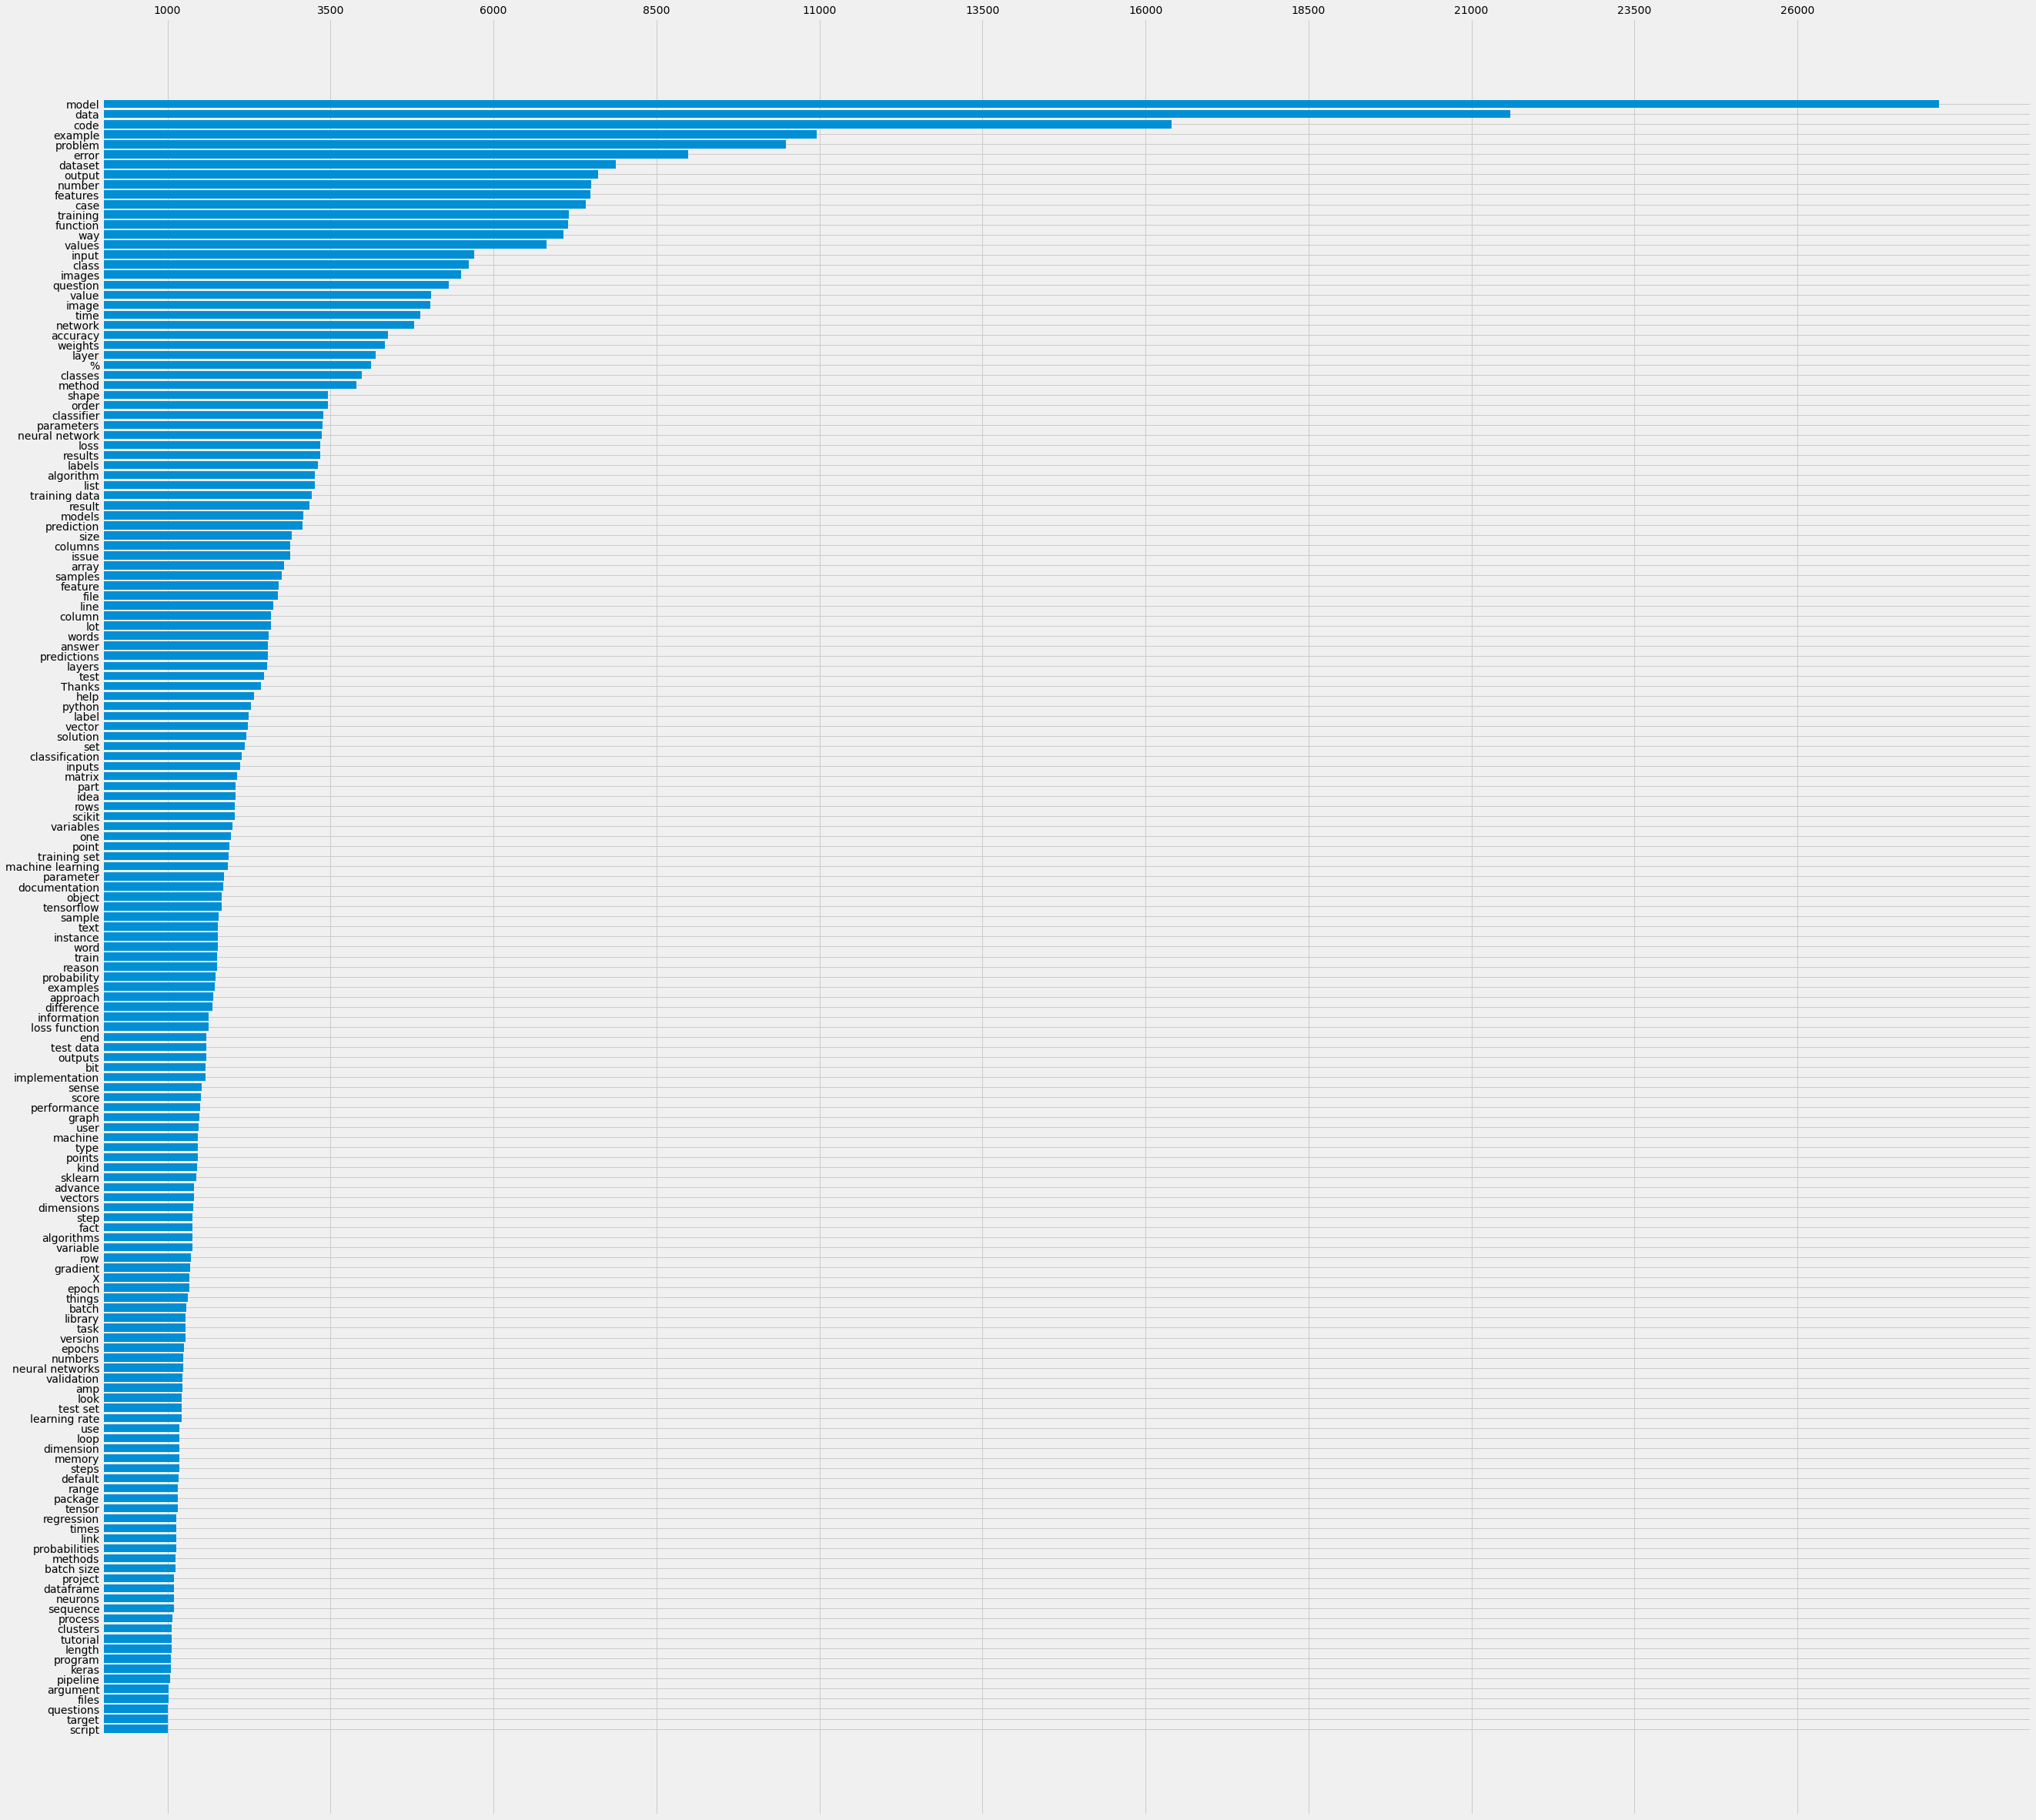

In [84]:
bigger_than_x_counter = Counter({k: c for k,c in sorted(topic_counter.items(), key=lambda item: item[1], reverse=False) if c >= 1000})

counter_sum = sum(bigger_than_x_counter.values())
print(counter_sum)
keys = list(bigger_than_x_counter.keys())
values = bigger_than_x_counter.values()



fig, ax = plt.subplots(figsize=(40,40))
plt.xticks(np.arange(min(values), max(values), 2500.0))
ax.xaxis.tick_top()
ax.barh(keys, values)



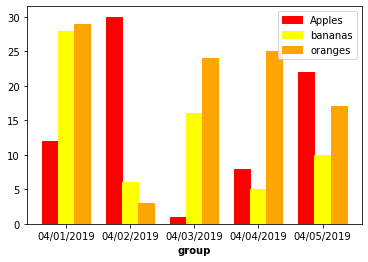

In [66]:
# libraries
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25

# set height of bar
bars1 = [12, 30, 1, 8, 22]
bars2 = [28, 6, 16, 5, 10]
bars3 = [29, 3, 24, 25, 17]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='#ff0000', width=barWidth, edgecolor='red', label='Apples')
plt.bar(r2, bars2, color='#FFFF00', width=barWidth, edgecolor='yellow', label='bananas')
plt.bar(r3, bars3, color='#FFA500', width=barWidth, edgecolor='orange', label='oranges')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['04/01/2019', '04/02/2019', '04/03/2019', '04/04/2019', '04/05/2019'])

# Create legend & Show graphic
plt.legend()
plt.show()

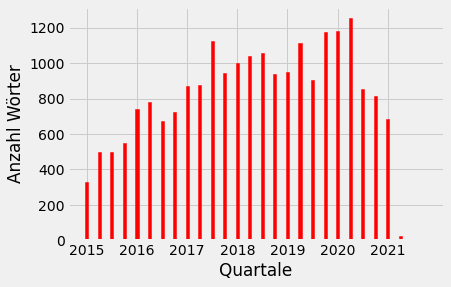

In [73]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
i = 0
for year in topic_frequency_dict:    
    for quarter in topic_frequency_dict[year]:
        plt.bar(i, topic_frequency_dict[year][quarter]["data"], color='#ff0000', width=0.25, edgecolor='red')
        i += 1        

plt.xlabel('Quartale')
plt.ylabel('Anzahl Wörter')
plt.xticks([r * 4 for r in range(2022-2015)], [year for year in range(2015, 2022)])       
plt.show()